In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import torch
import torch.nn as nn
import numpy as np

import os
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

## Preparing camera and dataset

In [29]:
def get_rays(datapath, mode='train'):

    pose_file_names = [f for f in os.listdir(datapath + f'/{mode}/pose') if f.endswith('.txt')]
    intrisics_file_names = [f for f in os.listdir(datapath + f'/{mode}/intrinsics') if f.endswith('.txt')]
    img_file_names = [f for f in os.listdir(datapath + '/imgs') if mode in f]

    assert len(pose_file_names) == len(intrisics_file_names)
    assert len(img_file_names) == len(pose_file_names)

    # Read
    N = len(pose_file_names)
    poses = np.zeros((N, 4, 4))
    intrinsics = np.zeros((N, 4, 4))

    images = []

    for i in range(N):
        name = pose_file_names[i]

        pose = open(datapath + f'/{mode}/pose/' + name).read().split()
        poses[i] = np.array(pose, dtype=float).reshape(4, 4)

        intrinsic = open(datapath + f'/{mode}/intrinsics/' + name).read().split()
        intrinsics[i] = np.array(intrinsic, dtype=float).reshape(4, 4)

        # Read images
        img = imageio.imread(datapath + '/imgs/' + name.replace('txt', 'png')) / 255.
        images.append(img[None, ...])
    images = np.concatenate(images)

    H = images.shape[1]
    W = images.shape[2]

    if images.shape[3] == 4: #RGBA -> RGB
        images = images[..., :3] * images[..., -1:] + (1 - images[..., -1:])

    rays_o = np.zeros((N, H*W, 3))
    rays_d = np.zeros((N, H*W, 3))
    target_px_values = images.reshape((N, H*W, 3))

    for i in range(N):

        c2w = poses[i]
        f = intrinsics[i, 0, 0]

        u = np.arange(W)
        v = np.arange(H)
        u, v = np.meshgrid(u, v)
        dirs = np.stack((u - W / 2, -(v - H / 2), - np.ones_like(u) * f), axis=-1)
        dirs = (c2w[:3, :3] @ dirs[..., None]).squeeze(-1)
        dirs = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True)

        rays_d[i] = dirs.reshape(-1, 3)
        rays_o[i] += c2w[:3, 3]

    return rays_o, rays_d, target_px_values


## Volumetric Rendering

In [41]:
def compute_accumulated_transmittance(betas):
    """
    Computes the accumulated transmittance given a tensor of betas

    Args:
        betas (torch.Tensor): A tensor of shape (batch_size, num_layers) containing the betas for each layer

    Returns:
        torch.Tensor: A tensor of shape (batch_size, num_layers) containing the accumulated transmittance for each layer
    """
    accumulated_transmittance = torch.cumprod(betas, 1)
    return torch.cat(
        (
            torch.ones(accumulated_transmittance.shape[0], 1, device=accumulated_transmittance.device),
            accumulated_transmittance[:, :-1]
        ),
        dim=1
    )

def rendering(model, rays_o, rays_d, tn, tf, nb_bins=100, device='cpu', white_bckgr=True):
    """
    Renders an image of a 3D scene using volumetric rendering.

    Args:
    - model: a model that predicts the color and density at each point in space
    - rays_o: the origin of the rays, shape [nb_rays, 3]
    - rays_d: the direction of the rays, shape [nb_rays, 3]
    - tn: the near clipping distance, a float
    - tf: the far clipping distance, a float
    - nb_bins: the number of bins to discretize the rays with, an integer
    - device: the device to run the computation on, a string
    - white_bckgr: whether to assume a white background, a boolean

    Returns:
    - c: the rendered image, shape [nb_rays, 3]
    """

    # Discretize the rays
    t = torch.linspace(tn, tf, nb_bins).to(device)  # [nb_bins]
    delta = torch.cat((t[1:] - t[:-1], torch.tensor([1e10], device=device)))
    x = rays_o.unsqueeze(1) + t.unsqueeze(0).unsqueeze(-1) * rays_d.unsqueeze(1)  # [nb_rays, nb_bins, 3]

    # Query the model for the colors and density along the rays
    colors, density = model.intersect(x.reshape(-1, 3), rays_d.expand(x.shape[1], x.shape[0], 3).transpose(0, 1).reshape(-1, 3))
    colors = colors.reshape((x.shape[0], nb_bins, 3))  # [nb_rays, nb_bins, 3]
    density = density.reshape((x.shape[0], nb_bins))

    # Compute the accumulated transmittance and the weights
    alpha = 1 - torch.exp(- density * delta.unsqueeze(0))  # [nb_rays, nb_bins, 1]
    weights = compute_accumulated_transmittance(1 - alpha) * alpha  # [nb_rays, nb_bins]

    # Compute the final color
    if white_bckgr:
        c = (weights.unsqueeze(-1) * colors).sum(1)  # [nb_rays, 3]
        weight_sum = weights.sum(-1)  # [nb_rays]
        return c + 1 - weight_sum.unsqueeze(-1)
    else:
        c = (weights.unsqueeze(-1) * colors).sum(1)  # [nb_rays, 3]
        return c


## NeRF model

In [31]:
class Nerf(nn.Module):

    def __init__(self, Lpos=10, Ldir=4, hidden_dim=256):
        super(Nerf, self).__init__()

        # Block 1: A set of fully connected layers with ReLU activations to process the input 3D coordinates.
        self.block1 = nn.Sequential(nn.Linear(Lpos * 6 + 3, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU())

        # Block 2: Another set of fully connected layers to further process the output of block 1, concatenated with the input.
        self.block2 = nn.Sequential(nn.Linear(hidden_dim + Lpos * 6 + 3, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim + 1),)

        # RGB Head: A set of layers to convert the processed 3D coordinates into RGB values.
        self.rgb_head = nn.Sequential(nn.Linear(hidden_dim + Ldir * 6 + 3, hidden_dim // 2), nn.ReLU(),
                                      nn.Linear(hidden_dim // 2, 3), nn.Sigmoid())

        # Length of positional encoding for 3D coordinates and viewing direction.
        self.Lpos = Lpos
        self.Ldir = Ldir

    def positional_encoding(self, x, L):
        # This method applies positional encoding to the input.
        # It uses both sine and cosine functions with different frequencies to encode spatial relationships.
        # ORIGINAL PAPER MULTIPLIES BY PIE
        out = [x]
        for j in range(L):
            out.append(torch.sin(2 ** j * x))
            out.append(torch.cos(2 ** j * x))
        return torch.cat(out, dim=1)

    def forward(self, xyz, d):
        # Forward pass: Processes 3D coordinates (xyz) and viewing direction (d) to produce RGB values and volume density.

        # Applying positional encoding to 3D coordinates and viewing direction.
        x_emb = self.positional_encoding(xyz, self.Lpos) # [batch_size, Lpos * 6 + 3]
        d_emb = self.positional_encoding(d, self.Ldir) # [batch_size, Ldir * 6 + 3]

        # Passing through the first block of layers.
        h = self.block1(x_emb) # [batch_size, hidden_dim]

        # Concatenating the result with the original positional encoding and passing through the second block.
        h = self.block2(torch.cat((h, x_emb), dim=1)) # [batch_size, hidden_dim + 1]

        # Extracting the volume density (sigma) and truncating the hidden representation (h).
        sigma = h[:, -1]
        h = h[:, :-1] # [batch_size, hidden_dim]

        # Getting the RGB values by passing the truncated hidden representation and viewing direction encoding through the RGB head.
        c = self.rgb_head(torch.cat((h, d_emb), dim=1))

        return c, torch.relu(sigma) # Returning RGB values and volume density.

    def intersect(self, x, d):
        # Convenience method for calling the forward method.
        return self.forward(x, d)


In [32]:
from tqdm import tqdm

def training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, data_loader, device='cpu'):

    training_loss = []
    for epoch in (range(nb_epochs)):
        for batch in tqdm(data_loader):
            o = batch[:, :3].to(device)
            d = batch[:, 3:6].to(device)

            target = batch[:, 6:].to(device)

            prediction = rendering(model, o, d, tn, tf, nb_bins=nb_bins, device=device)

            loss = ((prediction - target)**2).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            training_loss.append(loss.item())

        scheduler.step()

        torch.save(model.cpu(), 'model_nerf')
        model.to(device)

    return training_loss

## Camera/Dataset

In [47]:
batch_size = 1024

o, d, target_px_values = get_rays('/content/drive/MyDrive/dev/NeRF/fox', mode='train')
dataloader = DataLoader(torch.cat((torch.from_numpy(o).reshape(-1, 3).type(torch.float),
                                   torch.from_numpy(d).reshape(-1, 3).type(torch.float),
                                   torch.from_numpy(target_px_values).reshape(-1, 3).type(torch.float),), dim=1),
                       batch_size=batch_size, shuffle=True)


dataloader_warmup = DataLoader(torch.cat((torch.from_numpy(o).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float),
                               torch.from_numpy(d).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float),
                               torch.from_numpy(target_px_values).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3)), dim=1).type(torch.float),
                       batch_size=batch_size, shuffle=True)


test_o, test_d, test_target_px_values = get_rays('/content/drive/MyDrive/dev/NeRF/fox', mode='test')

<ipython-input-29-c69b9c1e21df>:27: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(datapath + '/imgs/' + name.replace('txt', 'png')) / 255.


In [39]:
torch.from_numpy(o).dtype

torch.float64

## Training

In [34]:
device = torch.device("cpu")

if torch.cuda.is_available():
   print("Training on GPU")
   device = torch.device("cuda:0")

Training on GPU


100%|██████████| 3516/3516 [07:38<00:00,  7.67it/s]


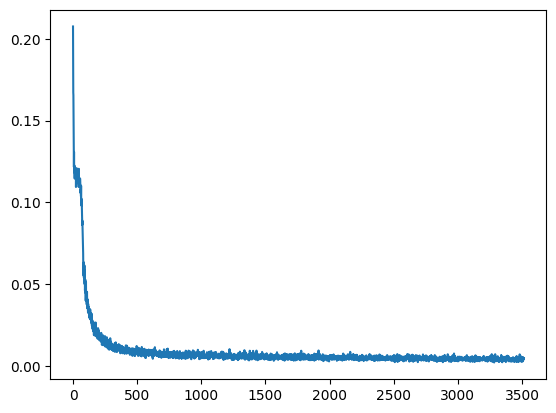

 81%|████████  | 11405/14063 [24:30<05:40,  7.81it/s]

In [ ]:
tn = 8
tf = 12
nb_epochs = 1
lr = 1e-3
gamma = .5
nb_bins = 100

model = Nerf().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10], gamma=gamma)


training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, 1, dataloader_warmup, device=device)
plt.plot(training_loss)
plt.show()
training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, dataloader, device=device)
plt.plot(training_loss)
plt.show()

##Novel View Synthesis

In [50]:
test_o, test_d, test_target_px_values = get_rays('/content/drive/MyDrive/dev/NeRF/fox', mode='test')

<ipython-input-29-c69b9c1e21df>:27: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(datapath + '/imgs/' + name.replace('txt', 'png')) / 255.


In [51]:
device = 'cuda'
tn = 8.
tf = 12.

In [52]:
model = torch.load('model_nerf').to(device)

In [53]:
def mse2psnr(mse):
    return 20 * np.log10(1 / np.sqrt(mse))


@torch.no_grad()
def test(model, o, d, tn, tf, nb_bins=100, chunk_size=10, H=400, W=400, target=None):

    o = o.chunk(chunk_size)
    d = d.chunk(chunk_size)

    image = []
    for o_batch, d_batch in zip(o, d):
        img_batch = rendering(model, o_batch, d_batch, tn, tf, nb_bins=nb_bins, device=o_batch.device)
        image.append(img_batch) # N, 3
    image = torch.cat(image)
    image = image.reshape(H, W, 3).cpu().numpy()

    if target is not None:
        mse = ((image - target)**2).mean()
        psnr = mse2psnr(mse)

    if target is not None:
        return image, mse, psnr
    else:
        return image

In [54]:
img, mse, psnr = test(model, torch.from_numpy(test_o[0]).to(device).float(), torch.from_numpy(test_d[0]).to(device).float(),
                tn, tf, nb_bins=100, chunk_size=10, target=test_target_px_values[0].reshape(400, 400, 3))

print(psnr)

29.846612226373715


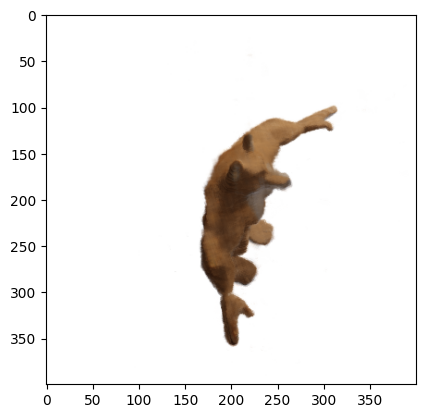

In [55]:
plt.imshow(img)